In [7]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from tqdm.notebook import tqdm
from itertools import product


In [8]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

## Посмотрим на наши данные

In [9]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


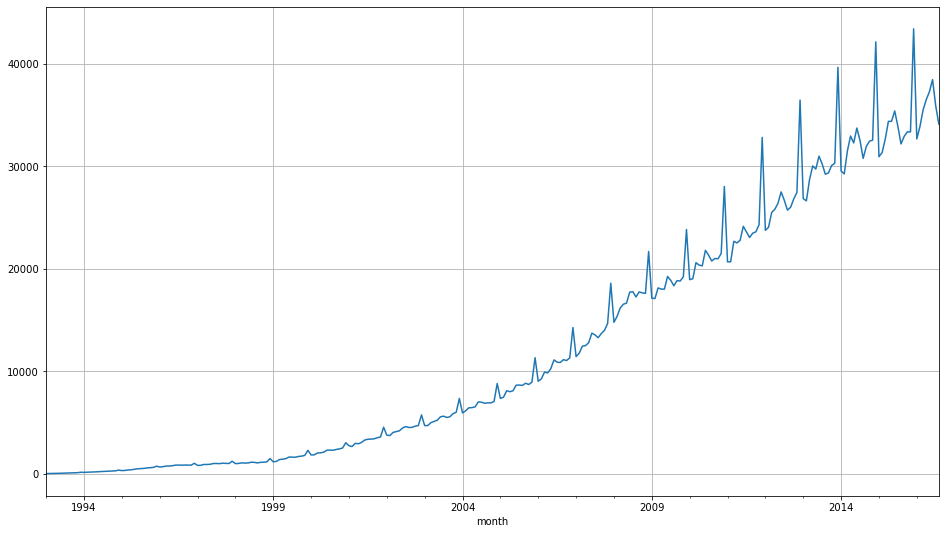

In [10]:
plt.figure(figsize=(16,9))
data.WAG_C_M.plot()
plt.grid()

<Figure size 1080x720 with 0 Axes>

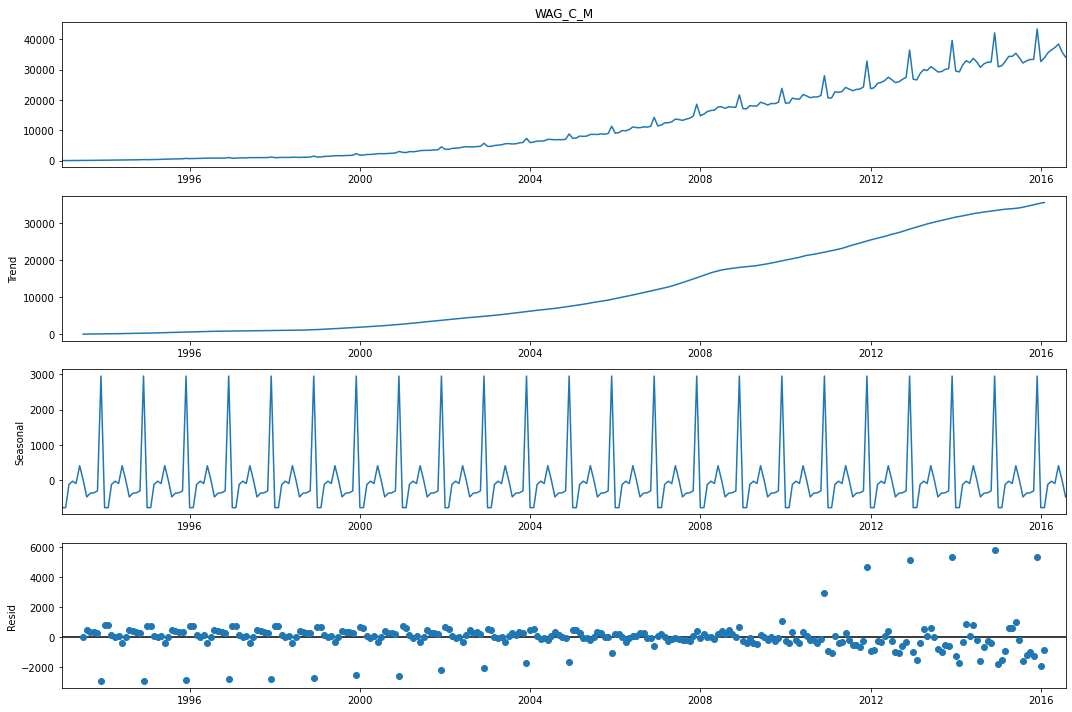

In [11]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
plt.show()

Разложив ряд по мы можем заметить, что в нем ярко выражена сезонность и тренд, при этом дисперсия с каждым годом растет, попробуем привести наш ряд к стационарному.

## Подберем необходимый параметр преобразования Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


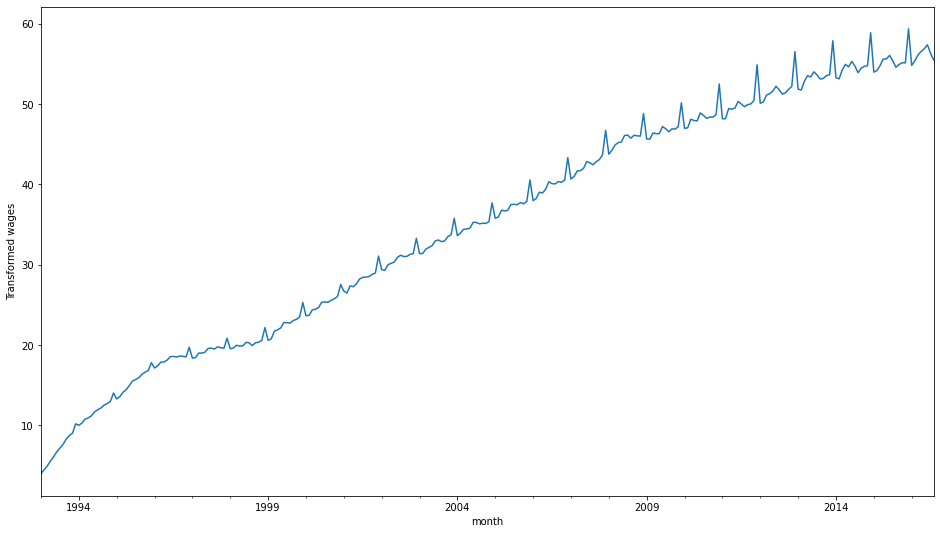

In [12]:
data['box'], lmbda = sps.boxcox(data.WAG_C_M)
plt.figure(figsize=(16,9))
data.box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box)[1])

На графике можно пронаблюдать, что дисперсия со временем хоть и растет, однако уже не так сильно, как на сырых данных. Но Критерий Дики-Фуллера дает p-value=0.69689, что не позволяет нам отвергнуть гипотезу о нестационарности

## Теперь продифференциируем достаточное число раз наши данные, чтобы получить стационарный временной ряд

Наш ряд имеет ярковыраженную годовую сезонность - применим сезонное дифференциирование с сезоном в год

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

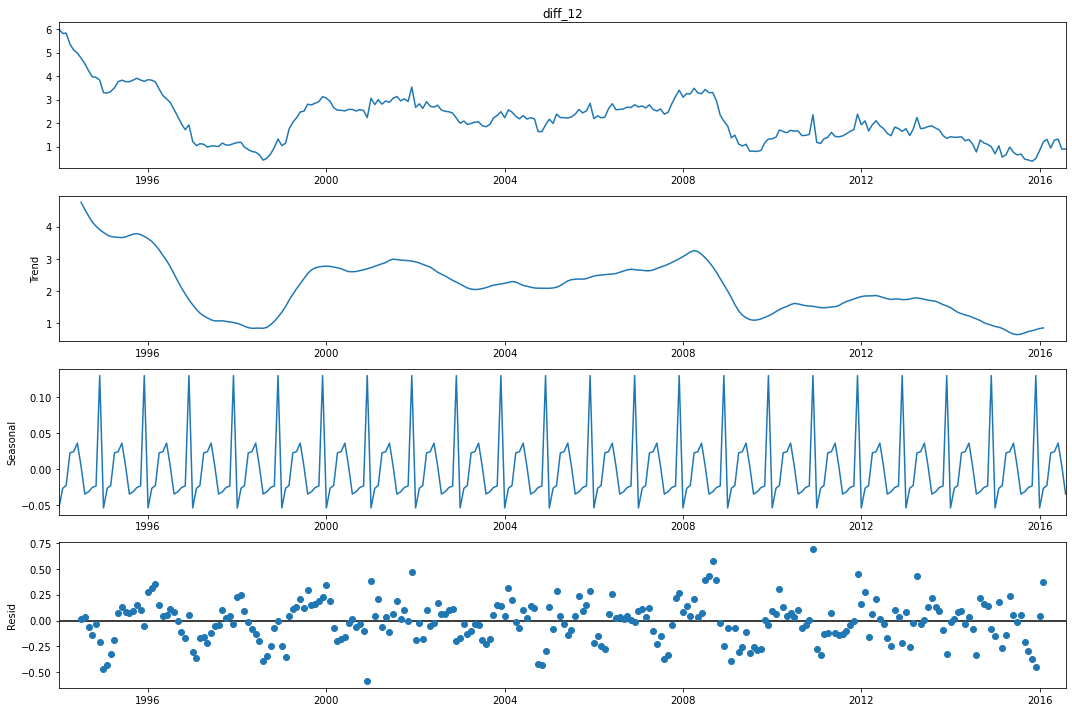

In [13]:
data['diff_12'] = (data.box - data.box.shift(12))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.diff_12[12:])[1])
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data.diff_12[12:]).plot()
plt.show()

Критерий Дики-Фуллера отвергает гипотезу о нестационарности, однако, в нем все еще наблюдается тренд, значит, чтобы привести ряд к стационарному, необходимо еще раз продифференцировать его, чтобы учесть месячную сезонность.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

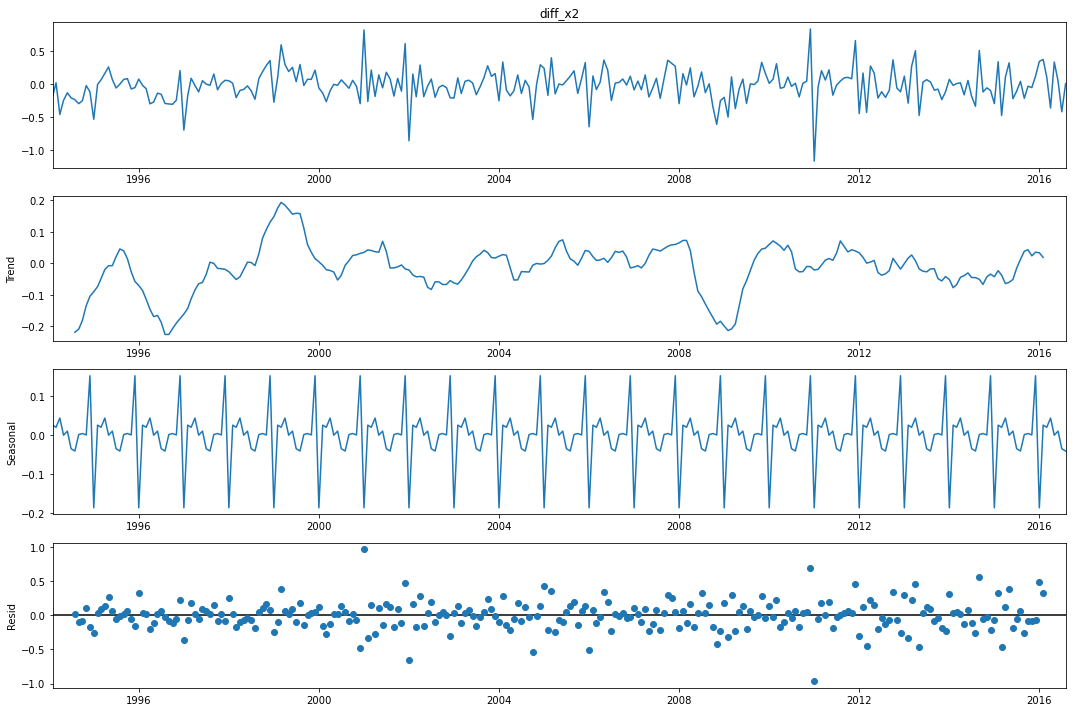

In [14]:
data['diff_x2'] = (data.diff_12 - data.diff_12.shift(1))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.diff_x2[13:])[1])
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data.diff_x2[13:]).plot()
plt.show()

Теперь наш ряд выглядит как стационарный, что подтверждается критерием Дики-Фуллера, теперь мы можем настраивать параметры модели ARIMA

## Подберем параметры модели

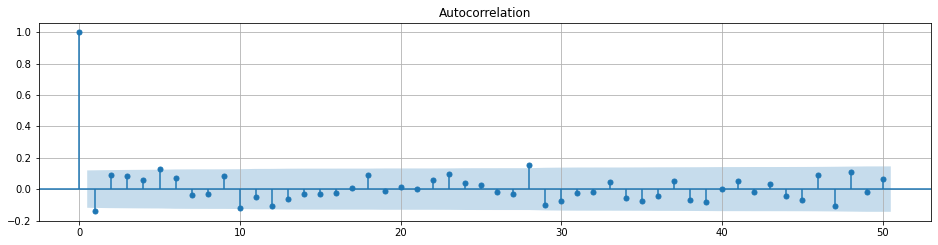

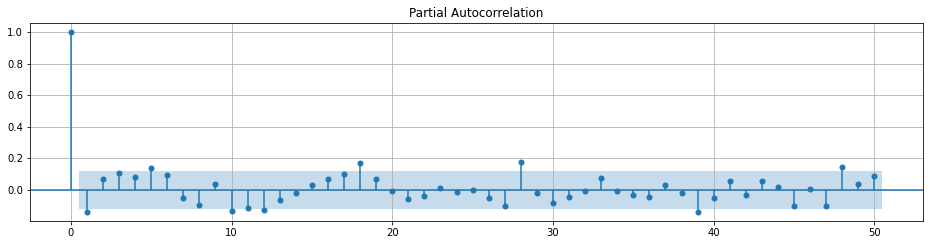

In [15]:
plt.figure(figsize(16,8))
ax = plt.subplot(211)
ax.grid()
sm.graphics.tsa.plot_acf(data.diff_x2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
ax.grid()
sm.graphics.tsa.plot_pacf(data.diff_x2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Изобразим автокорреляцию и частичную автокорреляцию ряда, получим начальное приближение для наших данных Q=1, q=10, P=1, p=5

In [23]:
ps = range (0, 11)
d=1
qs = range (0, 10)
Ps = range (0, 1)
D=1
Qs = range (0, 1)


In [24]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

110

In [33]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    
    try:
        model=sm.tsa.statespace.SARIMAX(data.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

C:\Users\user\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
55  (5, 5, 0, 0) -22.357632
22  (2, 2, 0, 0) -21.488595
23  (2, 3, 0, 0) -21.091475
74  (7, 4, 0, 0) -20.398726
65  (6, 5, 0, 0) -20.392143


C:\Users\user\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(0, 1, [], 12)   Log Likelihood                  22.179
Date:                             Sat, 28 Aug 2021   AIC                            -22.358
Time:                                     14:25:19   BIC                             17.266
Sample:                                 01-01-1993   HQIC                            -6.448
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2006      0.535     -0.375      0.708      -1.249       0.847
ar.L2          0.2494      

C:\Users\user\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Перебрав все возможные комбинации параметров до нашего начального приближения и сравних их по критерию Акаике, мы получили оптимальную модель ARIMA(5, 1, 5)x(0, 1, 0, 12)

## Проверим остатки модели

C:\Users\user\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.235925
Критерий Дики-Фуллера: p=0.000000


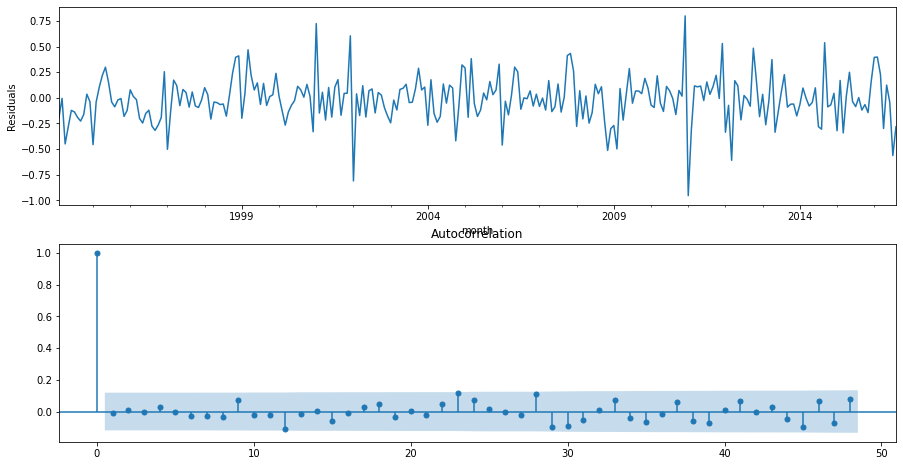

In [36]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % sps.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

График временного ряда похож на стационарный, что подтверждает критерий Дики-Фуллера, согласно критерию Стьюдента остатки не смещены, а также неавтокоррелированы, что видно по коррелограмме

In [37]:
best_model.fittedvalues

C:\Users\user\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


month
1993-01-01     0.000000
1993-02-01     3.990393
1993-03-01     4.458758
1993-04-01     4.931635
1993-05-01     5.549430
                ...    
2016-04-01    56.826003
2016-05-01    56.736376
2016-06-01    57.401015
2016-07-01    56.823252
2016-08-01    55.737967
Length: 284, dtype: float64

C:\Users\user\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


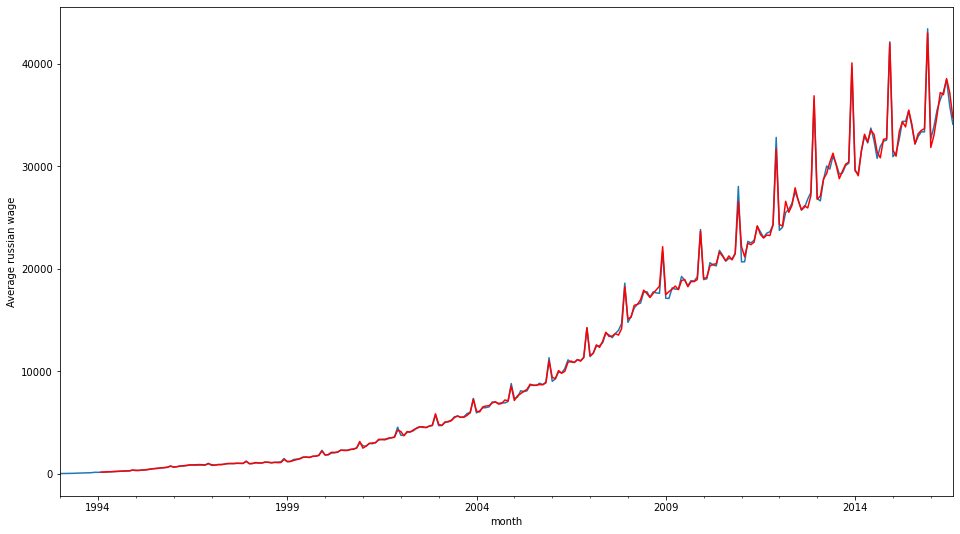

In [40]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(16,9))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Average russian wage')
plt.show()

Как можно заметить, красная ломаная довольно хорошо предсказывает реальные данные, значит построенная модель действительно корректно работает. Построим с ее помощью предсказания на следующие 2 года

In [47]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

C:\Users\user\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\user\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


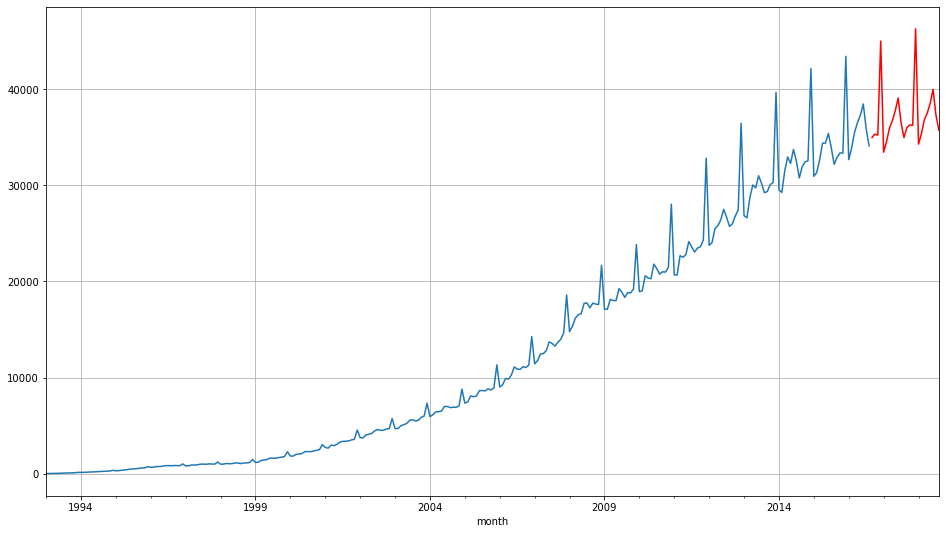

In [50]:
plt.figure(figsize=(16,9))
data.WAG_C_M.plot()
data2.forecast[-24:].plot(color='r')
plt.grid()
plt.show()